# Text Classification ML Project
## Automatic News Article Classification

### Problem Description
This project solves the problem of **automatic text classification** for news articles into different thematic categories. In the information age, where thousands of articles are published daily, automatic content categorization becomes crucial for:

- 📰 **News portals** - automatic tagging and sorting of articles
- 🔍 **Search engines** - better indexing and content recommendations  
- 📧 **Email systems** - filtering and categorization of messages
- 🏢 **Customer service departments** - automatic routing of inquiries to appropriate teams

### Problem Justification
- **Practical application**: Real-world problem in many IT industries
- **Data availability**: Well-documented dataset (20 Newsgroups)
- **Benchmarking opportunity**: Benchmark dataset allows comparison with other solutions
- **Educational aspect**: Enables learning the complete NLP pipeline

### Data Source
**Dataset**: 20 Newsgroups - classic benchmark dataset for text classification
- **Source**: Scikit-learn datasets
- **Size**: ~18,000 posts from Usenet discussion groups  
- **Categories**: 8 selected categories from original 20
- **Characteristics**: Authentic user texts, varied length, natural linguistic differences

### Selected Categories
1. `alt.atheism` - religious/philosophical discussions
2. `comp.graphics` - computer graphics  
3. `comp.os.ms-windows.misc` - Windows systems
4. `comp.sys.ibm.pc.hardware` - computer hardware
5. `rec.autos` - automotive
6. `rec.motorcycles` - motorcycles
7. `sci.space` - astronomy and space
8. `talk.politics.misc` - politics

## Installing Libraries


In [1]:
%pip install scikit-learn pandas numpy matplotlib seaborn wordcloud joblib


Note: you may need to restart the kernel to use updated packages.


## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pickle
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from wordcloud import WordCloud

## Setup

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Get the data

In [4]:
categories = [
    'alt.atheism',             
    'comp.graphics',           
    'comp.os.ms-windows.misc', 
    'comp.sys.ibm.pc.hardware',
    'rec.autos',                
    'rec.motorcycles',          
    'sci.space',                
    'talk.politics.misc'       
]

# training set
newsgroups_train = fetch_20newsgroups(
    subset='train', 
    categories=categories,
    shuffle=True, 
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

# test set
newsgroups_test = fetch_20newsgroups(
    subset='test', 
    categories=categories,
    shuffle=True, 
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

## Exploratory Data Analysis (EDA)

### Basic Statistics

In [5]:
text_lengths = [len(text.split()) for text in newsgroups_train.data]
char_lengths = [len(text) for text in newsgroups_train.data]

print("BASIC STATISTICS:")
print(f"   • Average text length: {np.mean(text_lengths):.0f} words")
print(f"   • Median text length: {np.median(text_lengths):.0f} words")
print(f"   • Shortest text: {np.min(text_lengths)} words")
print(f"   • Longest text: {np.max(text_lengths)} words")
print(f"   • Average character length: {np.mean(char_lengths):.0f} characters")

# Category distribution
category_counts = Counter(newsgroups_train.target)

print(f"\nCATEGORY DISTRIBUTION:")
print(f"{'Category':30} {'Number of texts':>15} {'Percent':>10}")
print("-" * 60)

for i, count in category_counts.items():
    category_name = newsgroups_train.target_names[i]
    percentage = (count / len(newsgroups_train.data)) * 100
    print(f"{category_name:30} {count:>15} {percentage:>9.1f}%")

BASIC STATISTICS:
   • Average text length: 162 words
   • Median text length: 74 words
   • Shortest text: 0 words
   • Longest text: 9109 words
   • Average character length: 1183 characters

CATEGORY DISTRIBUTION:
Category                       Number of texts    Percent
------------------------------------------------------------
rec.motorcycles                            598      13.3%
rec.autos                                  594      13.2%
alt.atheism                                480      10.7%
comp.graphics                              584      13.0%
talk.politics.misc                         465      10.3%
comp.os.ms-windows.misc                    591      13.1%
sci.space                                  593      13.2%
comp.sys.ibm.pc.hardware                   590      13.1%


In [6]:
# text length analysis
text_lengths_by_category = {}
for i, category in enumerate(newsgroups_train.target_names):
    category_indices = [idx for idx, target in enumerate(newsgroups_train.target) if target == i]
    category_lengths = [text_lengths[idx] for idx in category_indices]
    text_lengths_by_category[category.split('.')[-1]] = category_lengths

# Length statistics per category
print(f"AVERAGE TEXT LENGTH PER CATEGORY:")
print(f"{'Category':<15} {'Average':<10} {'Median':<10} {'Min':<8} {'Max':<8}")
print("-" * 55)

for category, lengths in text_lengths_by_category.items():
    print(f"{category:<15} {np.mean(lengths):<10.1f} {np.median(lengths):<10.1f} "
          f"{np.min(lengths):<8} {np.max(lengths):<8}")


AVERAGE TEXT LENGTH PER CATEGORY:
Category        Average    Median     Min      Max     
-------------------------------------------------------
atheism         194.4      91.0       0        8611    
graphics        157.8      62.0       0        9109    
misc            286.9      109.0      0        7952    
hardware        131.8      80.0       0        3983    
autos           116.3      69.5       0        4387    
motorcycles     107.8      65.0       0        5498    
space           202.3      82.0       0        6109    


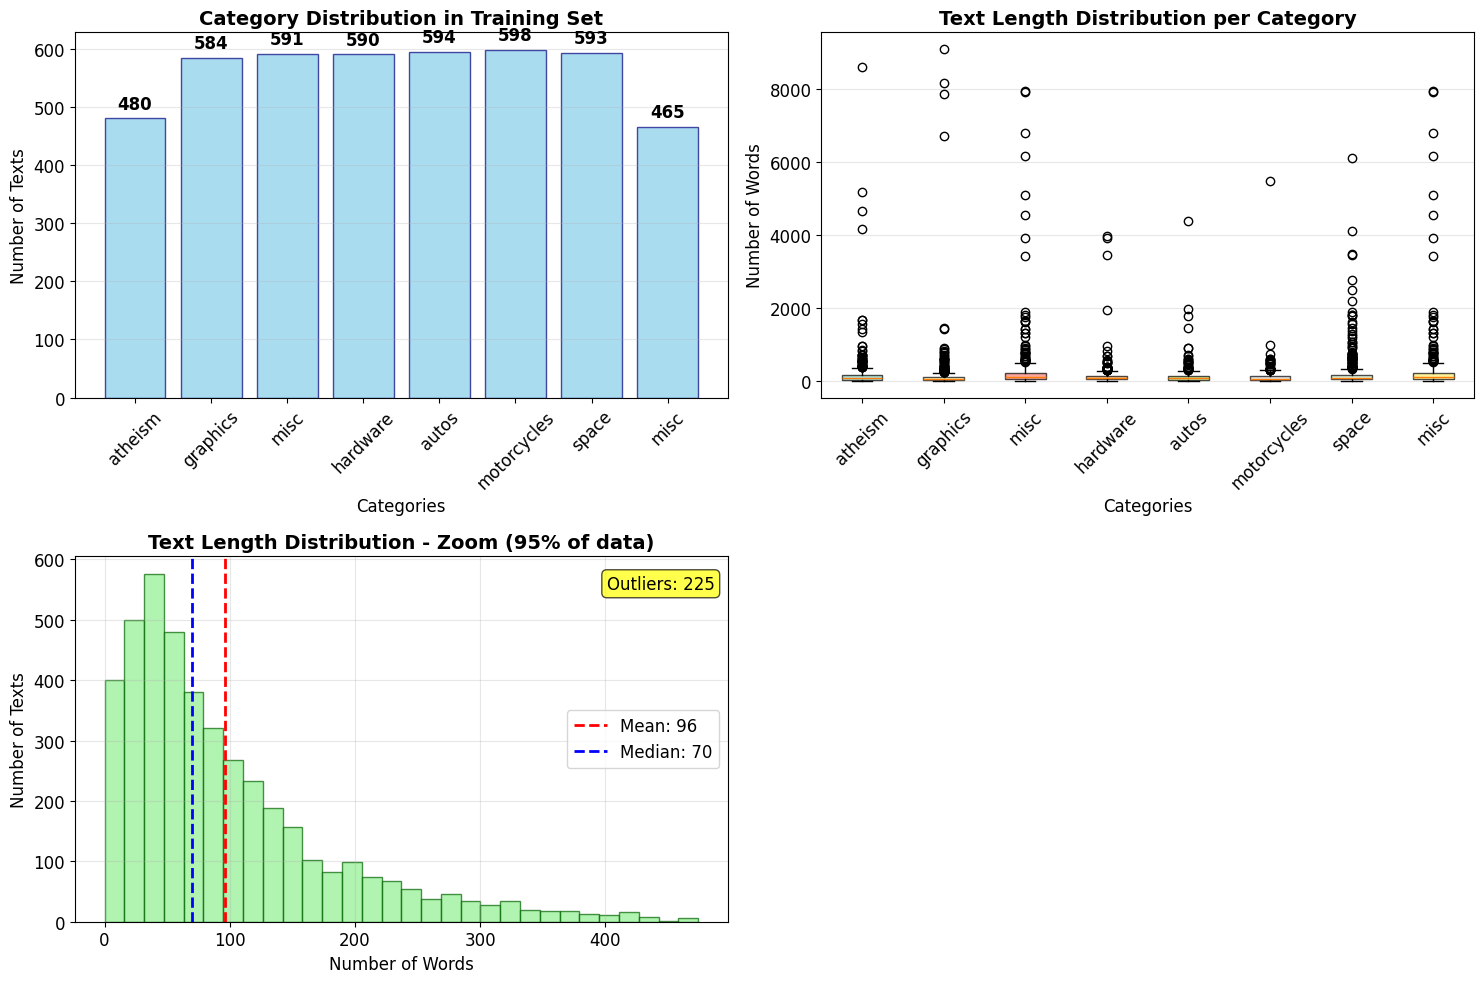

In [7]:
# visualizations
plt.figure(figsize=(15, 10))

# Chart 1: Category distribution
plt.subplot(2, 2, 1)
categories_short = [cat.split('.')[-1] for cat in newsgroups_train.target_names]
counts = [category_counts[i] for i in range(len(categories))]

bars = plt.bar(range(len(categories)), counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Category Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Texts')
plt.xticks(range(len(categories)), categories_short, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Chart 2: Box plot of lengths per category
plt.subplot(2, 2, 2)
category_lengths_list = [text_lengths_by_category[cat] for cat in categories_short]
box_plot = plt.boxplot(category_lengths_list, labels=categories_short, patch_artist=True)

# Coloring box plots
colors = plt.cm.Set3(np.linspace(0, 1, len(categories_short)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Text Length Distribution per Category', fontsize=14, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Chart 3: Length histogram (zoomed)
plt.subplot(2, 2, 3)
percentile_95 = np.percentile(text_lengths, 95)
filtered_lengths = [length for length in text_lengths if length <= percentile_95]

plt.hist(filtered_lengths, bins=30, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
plt.title(f'Text Length Distribution - Zoom (95% of data)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')

plt.axvline(np.mean(filtered_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(filtered_lengths):.0f}')
plt.axvline(np.median(filtered_lengths), color='blue', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(filtered_lengths):.0f}')

outliers_count = len(text_lengths) - len(filtered_lengths)
plt.text(0.98, 0.95, f'Outliers: {outliers_count}', 
         transform=plt.gca().transAxes, ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.legend()
plt.grid(alpha=0.3)

# Chart 4: Length analysis
plt.subplot(2, 2, 4)
plt.axis('off')

plt.tight_layout()
plt.show()


### Additional Data Analysis

In [8]:
# Analysis of missing/empty texts
empty_texts = sum(1 for text in newsgroups_train.data if len(text.strip()) == 0)
very_short_texts = sum(1 for text in newsgroups_train.data if len(text.split()) < 5)

print(f"DATA QUALITY ANALYSIS:")
print(f"   • Completely empty texts: {empty_texts}")
print(f"   • Very short texts (<5 words): {very_short_texts}")
print(f"   • Percentage of problematic texts: {(empty_texts + very_short_texts)/len(newsgroups_train.data)*100:.2f}%")

# Analysis of most frequent words in the entire corpus
from collections import Counter
import re

all_words = []
for text in newsgroups_train.data:
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    all_words.extend(words)

word_counts = Counter(all_words)
print(f"\nMOST FREQUENT WORDS IN CORPUS:")
for word, count in word_counts.most_common(15):
    print(f"   • '{word}': {count:,} occurrences")

# Check unique words per category
unique_words_per_category = {}
for i, category in enumerate(newsgroups_train.target_names):
    category_texts = [newsgroups_train.data[idx] for idx, target in enumerate(newsgroups_train.target) if target == i]
    category_words = set()
    for text in category_texts:
        words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
        category_words.update(words)
    unique_words_per_category[category.split('.')[-1]] = len(category_words)

print(f"\nUNIQUE WORDS PER CATEGORY:")
for category, count in sorted(unique_words_per_category.items(), key=lambda x: x[1], reverse=True):
    print(f"   • {category}: {count:,} unique words")


DATA QUALITY ANALYSIS:
   • Completely empty texts: 135
   • Very short texts (<5 words): 174
   • Percentage of problematic texts: 6.87%

MOST FREQUENT WORDS IN CORPUS:
   • 'the': 35,488 occurrences
   • 'and': 14,378 occurrences
   • 'that': 9,866 occurrences
   • 'for': 7,434 occurrences
   • 'you': 6,954 occurrences
   • 'this': 5,175 occurrences
   • 'have': 4,911 occurrences
   • 'max': 4,523 occurrences
   • 'are': 4,507 occurrences
   • 'with': 4,478 occurrences
   • 'not': 4,206 occurrences
   • 'but': 3,459 occurrences
   • 'was': 3,025 occurrences
   • 'can': 2,952 occurrences
   • 'from': 2,857 occurrences

UNIQUE WORDS PER CATEGORY:
   • space: 11,814 unique words
   • misc: 10,012 unique words
   • graphics: 9,054 unique words
   • atheism: 8,532 unique words
   • motorcycles: 7,669 unique words
   • autos: 7,460 unique words
   • hardware: 6,500 unique words


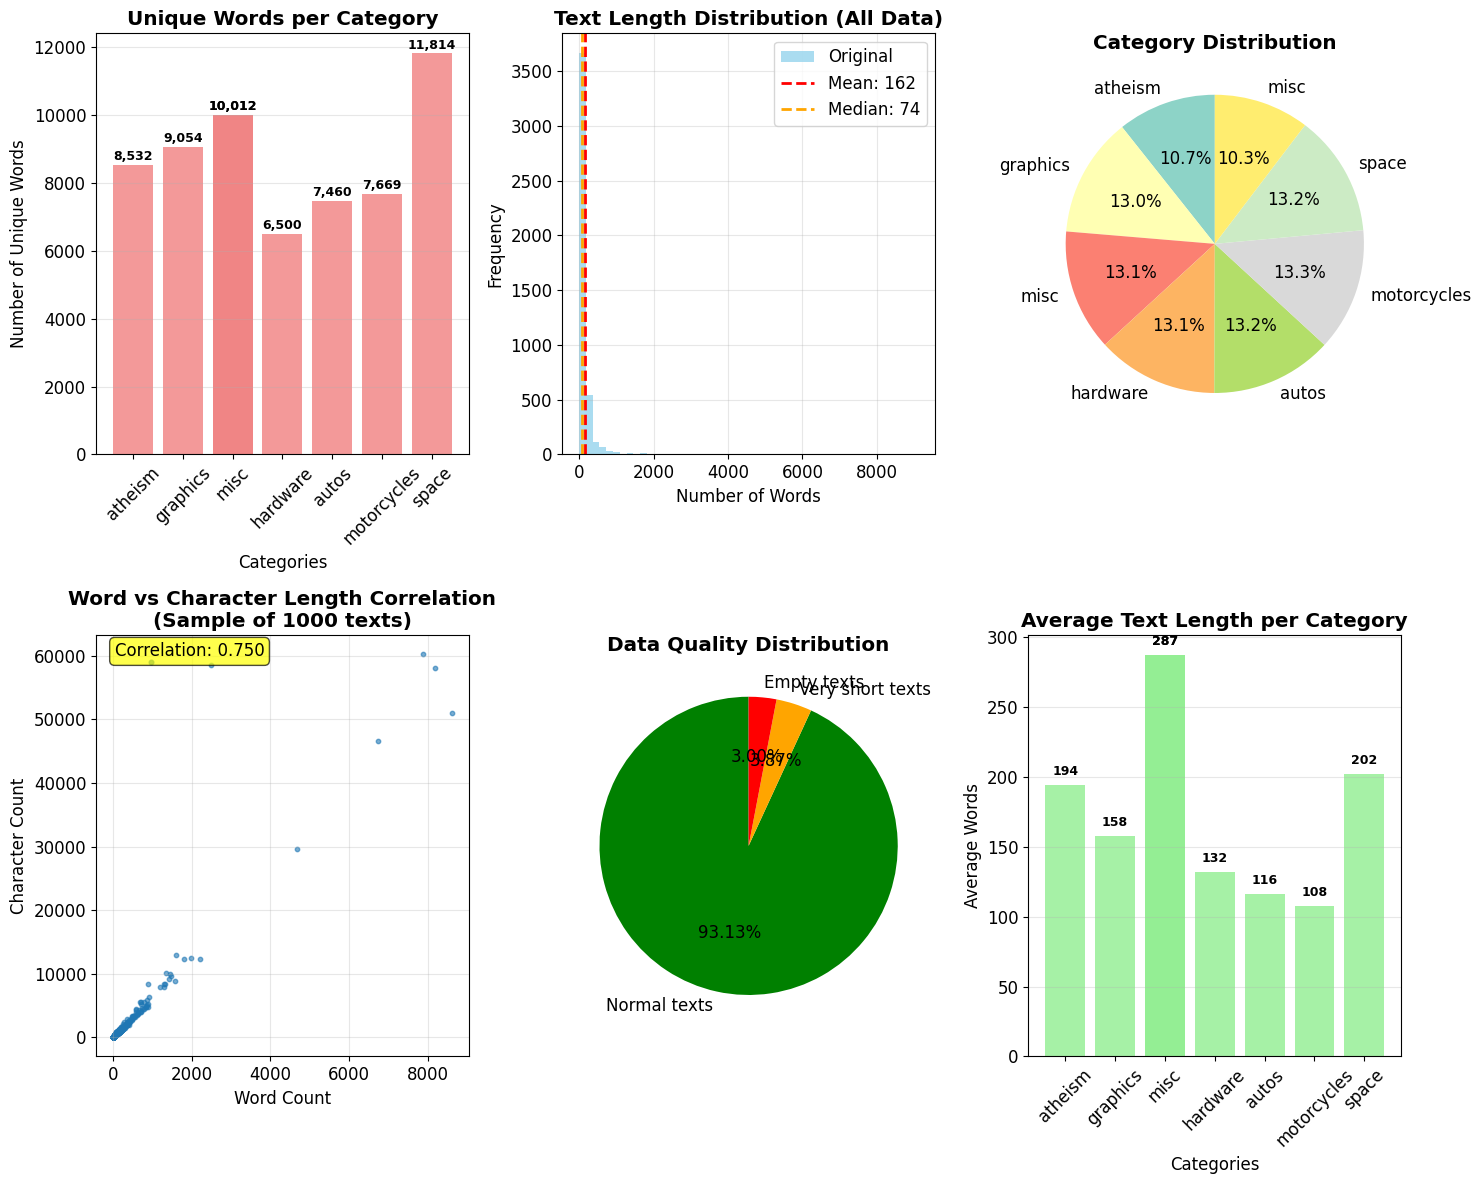


SUMMARY STATISTICS:
Total training samples: 4,495
Total test samples: 2,992
Number of categories: 8
Total vocabulary size (approx): 37,785
Average words per text: 162.1
Median words per text: 74.0
Standard deviation: 474.1
Data quality: 93.1% usable


In [9]:
# Additional visualizations for EDA
plt.figure(figsize=(15, 12))

# 1. Category-specific word frequency analysis
plt.subplot(2, 3, 1)
categories_short = [cat.split('.')[-1] for cat in newsgroups_train.target_names]
word_counts_list = [unique_words_per_category[cat] for cat in categories_short]

bars = plt.bar(categories_short, word_counts_list, color='lightcoral', alpha=0.8)
plt.title('Unique Words per Category', fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Unique Words')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, count in zip(bars, word_counts_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Text length distribution comparison
plt.subplot(2, 3, 2)
plt.hist(text_lengths, bins=50, alpha=0.7, label='Original', color='skyblue')
plt.axvline(np.mean(text_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(text_lengths):.0f}')
plt.axvline(np.median(text_lengths), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(text_lengths):.0f}')
plt.title('Text Length Distribution (All Data)', fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

# 3. Category balance visualization (pie chart)
plt.subplot(2, 3, 3)
category_counts = Counter(newsgroups_train.target)
counts = [category_counts[i] for i in range(len(categories))]
colors = plt.cm.Set3(np.linspace(0, 1, len(categories_short)))

plt.pie(counts, labels=categories_short, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Category Distribution', fontweight='bold')

# 4. Character vs Word length correlation
plt.subplot(2, 3, 4)
char_lengths = [len(text) for text in newsgroups_train.data]
plt.scatter(text_lengths[:1000], char_lengths[:1000], alpha=0.6, s=10)
plt.xlabel('Word Count')
plt.ylabel('Character Count')
plt.title('Word vs Character Length Correlation\n(Sample of 1000 texts)', fontweight='bold')
plt.grid(alpha=0.3)

# Add correlation coefficient
correlation = np.corrcoef(text_lengths, char_lengths)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# 5. Data quality issues visualization
plt.subplot(2, 3, 5)
quality_labels = ['Normal texts', 'Very short texts', 'Empty texts']
quality_counts = [len(newsgroups_train.data) - very_short_texts - empty_texts, very_short_texts, empty_texts]
colors = ['green', 'orange', 'red']

plt.pie(quality_counts, labels=quality_labels, autopct='%1.2f%%', colors=colors, startangle=90)
plt.title('Data Quality Distribution', fontweight='bold')

# 6. Average text length per category (bar chart)
plt.subplot(2, 3, 6)
avg_lengths = []
for category in categories_short:
    category_lengths = text_lengths_by_category[category]
    avg_lengths.append(np.mean(category_lengths))

bars = plt.bar(categories_short, avg_lengths, color='lightgreen', alpha=0.8)
plt.title('Average Text Length per Category', fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Average Words')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, length in zip(bars, avg_lengths):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{length:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\nSUMMARY STATISTICS:")
print("=" * 50)
print(f"Total training samples: {len(newsgroups_train.data):,}")
print(f"Total test samples: {len(newsgroups_test.data):,}")
print(f"Number of categories: {len(categories)}")
print(f"Total vocabulary size (approx): {len(word_counts):,}")
print(f"Average words per text: {np.mean(text_lengths):.1f}")
print(f"Median words per text: {np.median(text_lengths):.1f}")
print(f"Standard deviation: {np.std(text_lengths):.1f}")
print(f"Data quality: {((len(newsgroups_train.data) - very_short_texts - empty_texts)/len(newsgroups_train.data)*100):.1f}% usable")


## Data Preprocessing

In [10]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

sample_text = "Hello WORLD!!! This is a test... with 123 numbers & special chars @#$%"
processed_text = preprocess_text(sample_text)

print(f"Before: {sample_text}")
print(f"After:  {processed_text}")

# Preprocessing all texts
print(f"\nPreprocessing {len(newsgroups_train.data)} training texts...")
X_train_raw = [preprocess_text(text) for text in newsgroups_train.data]

print(f"Preprocessing {len(newsgroups_test.data)} test texts...")
X_test_raw = [preprocess_text(text) for text in newsgroups_test.data]

y_train = newsgroups_train.target
y_test = newsgroups_test.target

print(f"   • Training texts: {len(X_train_raw)}")
print(f"   • Test texts: {len(X_test_raw)}")
processed_lengths = [len(text.split()) for text in X_train_raw]
print(f"   • Average length: {np.mean(processed_lengths):.0f} words")
print(f"   • Length reduction: {np.mean(text_lengths) - np.mean(processed_lengths):.0f} words")

Before: Hello WORLD!!! This is a test... with 123 numbers & special chars @#$%
After:  hello world this is a test with 123 numbers special chars

Preprocessing 4495 training texts...
Preprocessing 2992 test texts...
   • Training texts: 4495
   • Test texts: 2992
   • Average length: 159 words
   • Length reduction: 3 words


## TF-IDF VECTORIZATION

In [11]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,     # Top 10k most important words
    min_df=2,               # Word must occur at least 2 times
    max_df=0.95,            # Ignore words in >95% of documents
    stop_words='english',   # Remove English stop words
    ngram_range=(1, 2)      # Unigrams and bigrams
)

X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

print(f"TF-IDF matrix created!")
print(f"   • Training shape: {X_train_tfidf.shape}")
print(f"   • Test shape: {X_test_tfidf.shape}")
print(f"   • Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"   • Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.3f}")


TF-IDF matrix created!
   • Training shape: (4495, 10000)
   • Test shape: (2992, 10000)
   • Vocabulary size: 10000
   • Sparsity: 0.995


## Word cloud

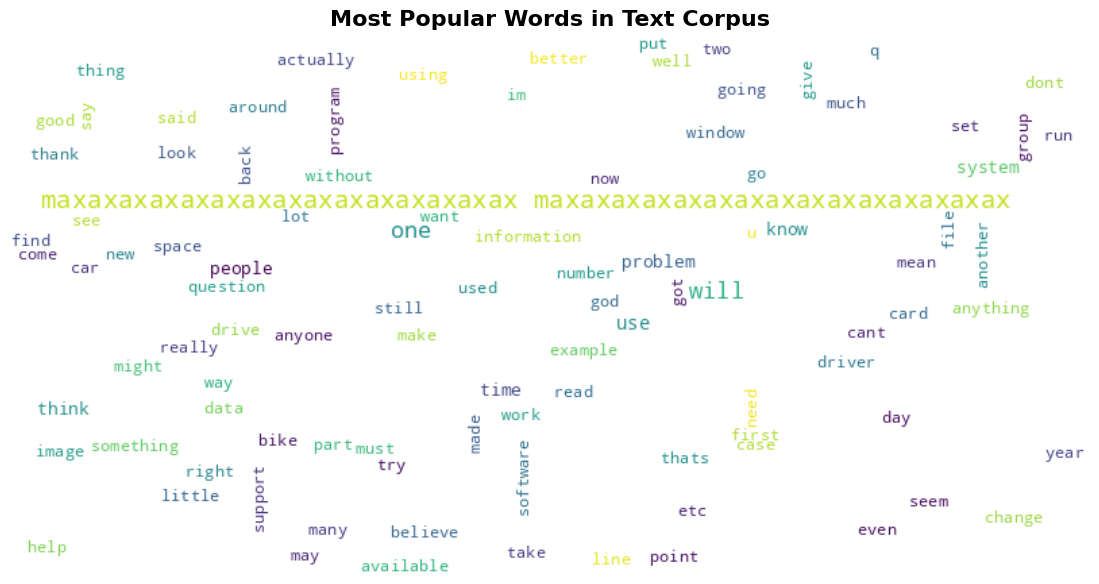

In [12]:
# Combine all texts
all_text = ' '.join(X_train_raw)

# Create word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=100,
    colormap='viridis',
    relative_scaling=0.5
).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Popular Words in Text Corpus', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Model training

In [13]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='linear', 
        random_state=42,
        probability=True
    )
}

print("ALGORITHMS TO TEST:")
for name, model in models.items():
    print(f"   • {name}")

# Training and evaluating models
results = {}
trained_models = {}

print(f"\nTRAINING MODELS...")
print("=" * 30)

for name, model in models.items():
    print(f"\nTraining: {name}")
    start_time = datetime.now()
    
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    
    # Save results
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred,
        'training_time': training_time,
        'model': model
    }
    
    trained_models[name] = model
    
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"   Training time: {training_time:.2f}s")

ALGORITHMS TO TEST:
   • Logistic Regression
   • Random Forest
   • SVM

TRAINING MODELS...

Training: Logistic Regression
   Accuracy: 0.7470 (74.7%)
   Training time: 5.41s

Training: Random Forest
   Accuracy: 0.6865 (68.6%)
   Training time: 0.32s

Training: SVM
   Accuracy: 0.7279 (72.8%)
   Training time: 22.23s


## Model results comparison 

Model                Accuracy   Time [s]   Position
--------------------------------------------------
Logistic Regression  0.7470     5.41       1
SVM                  0.7279     22.23      2
Random Forest        0.6865     0.32       3

BEST MODEL: Logistic Regression
Accuracy: 0.7470
Time: 5.41s


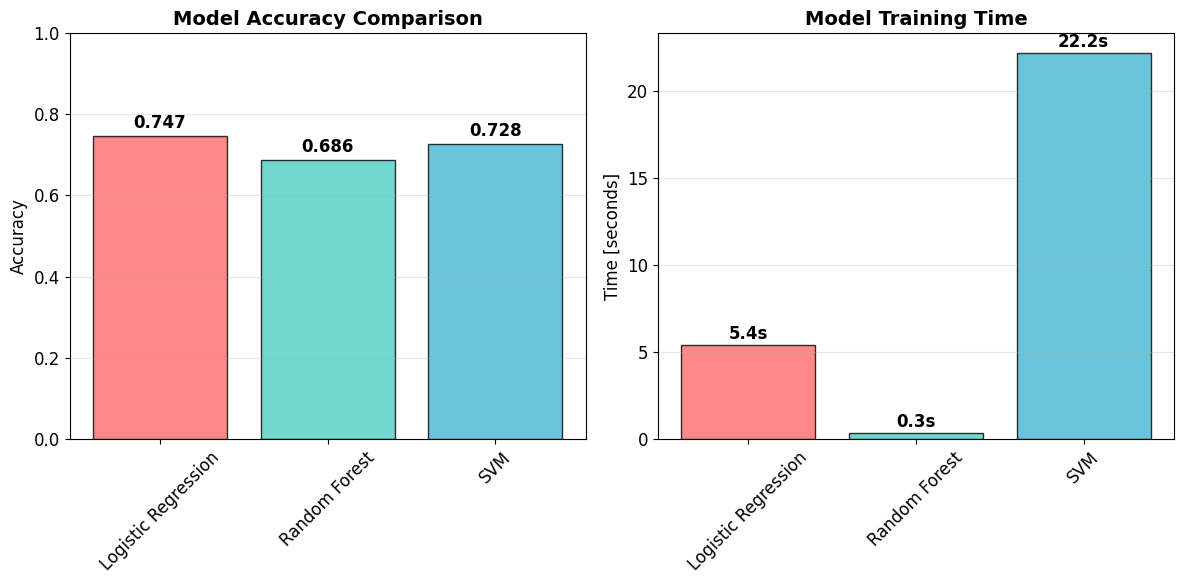

In [14]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print(f"{'Model':<20} {'Accuracy':<10} {'Time [s]':<10} {'Position':<8}")
print("-" * 50)

for i, (name, data) in enumerate(sorted_results, 1):
    print(f"{name:<20} {data['accuracy']:<10.4f} {data['training_time']:<10.2f} {i}")

# Best model
best_model_name = sorted_results[0][0]
best_model_data = sorted_results[0][1]
best_model = best_model_data['model']

print(f"\nBEST MODEL: {best_model_name}")
print(f"Accuracy: {best_model_data['accuracy']:.4f}")
print(f"Time: {best_model_data['training_time']:.2f}s")

# Comparison chart
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)

# Subplot 2: Training time
plt.subplot(1, 2, 2)
times = [results[name]['training_time'] for name in model_names]

bars2 = plt.bar(model_names, times, color=colors, alpha=0.8, edgecolor='black')
plt.title('Model Training Time', fontsize=14, fontweight='bold')
plt.ylabel('Time [seconds]')
plt.xticks(rotation=45)

# Add values on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Hyperparameter Tuning

### Grid Search for Best Model


In [ ]:
# Hyperparameter tuning for the best model (Logistic Regression)
# Get the current best results for comparison
current_final_accuracy = best_model_data['accuracy']

print(f"HYPERPARAMETER TUNING FOR: {best_model_name}")
print("=" * 50)

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000, 2000]
}

# Create GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search...")
start_time = datetime.now()

# Fit grid search
grid_search.fit(X_train_tfidf, y_train)

end_time = datetime.now()
tuning_time = (end_time - start_time).total_seconds()

print(f"\nGrid search completed in {tuning_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the optimized model
optimized_model = grid_search.best_estimator_
optimized_predictions = optimized_model.predict(X_test_tfidf)
optimized_accuracy = accuracy_score(y_test, optimized_predictions)

print(f"\nMODEL COMPARISON:")
print(f"Original accuracy:  {current_final_accuracy:.4f}")
print(f"Optimized accuracy: {optimized_accuracy:.4f}")
print(f"Improvement: {(optimized_accuracy - current_final_accuracy):.4f}")

# Update final model if better
if optimized_accuracy > current_final_accuracy:
    print("\n✅ Using optimized model as final model")
    # Update the results for later use
    results[best_model_name]['model'] = optimized_model
    results[best_model_name]['predictions'] = optimized_predictions
    results[best_model_name]['accuracy'] = optimized_accuracy
else:
    print("\n➡️ Original model performs better, keeping it")


HYPERPARAMETER TUNING FOR: Logistic Regression
Starting grid search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


## 5. Feature Importance Analysis

### 5.1 Most Important Features per Category


FEATURE IMPORTANCE ANALYSIS


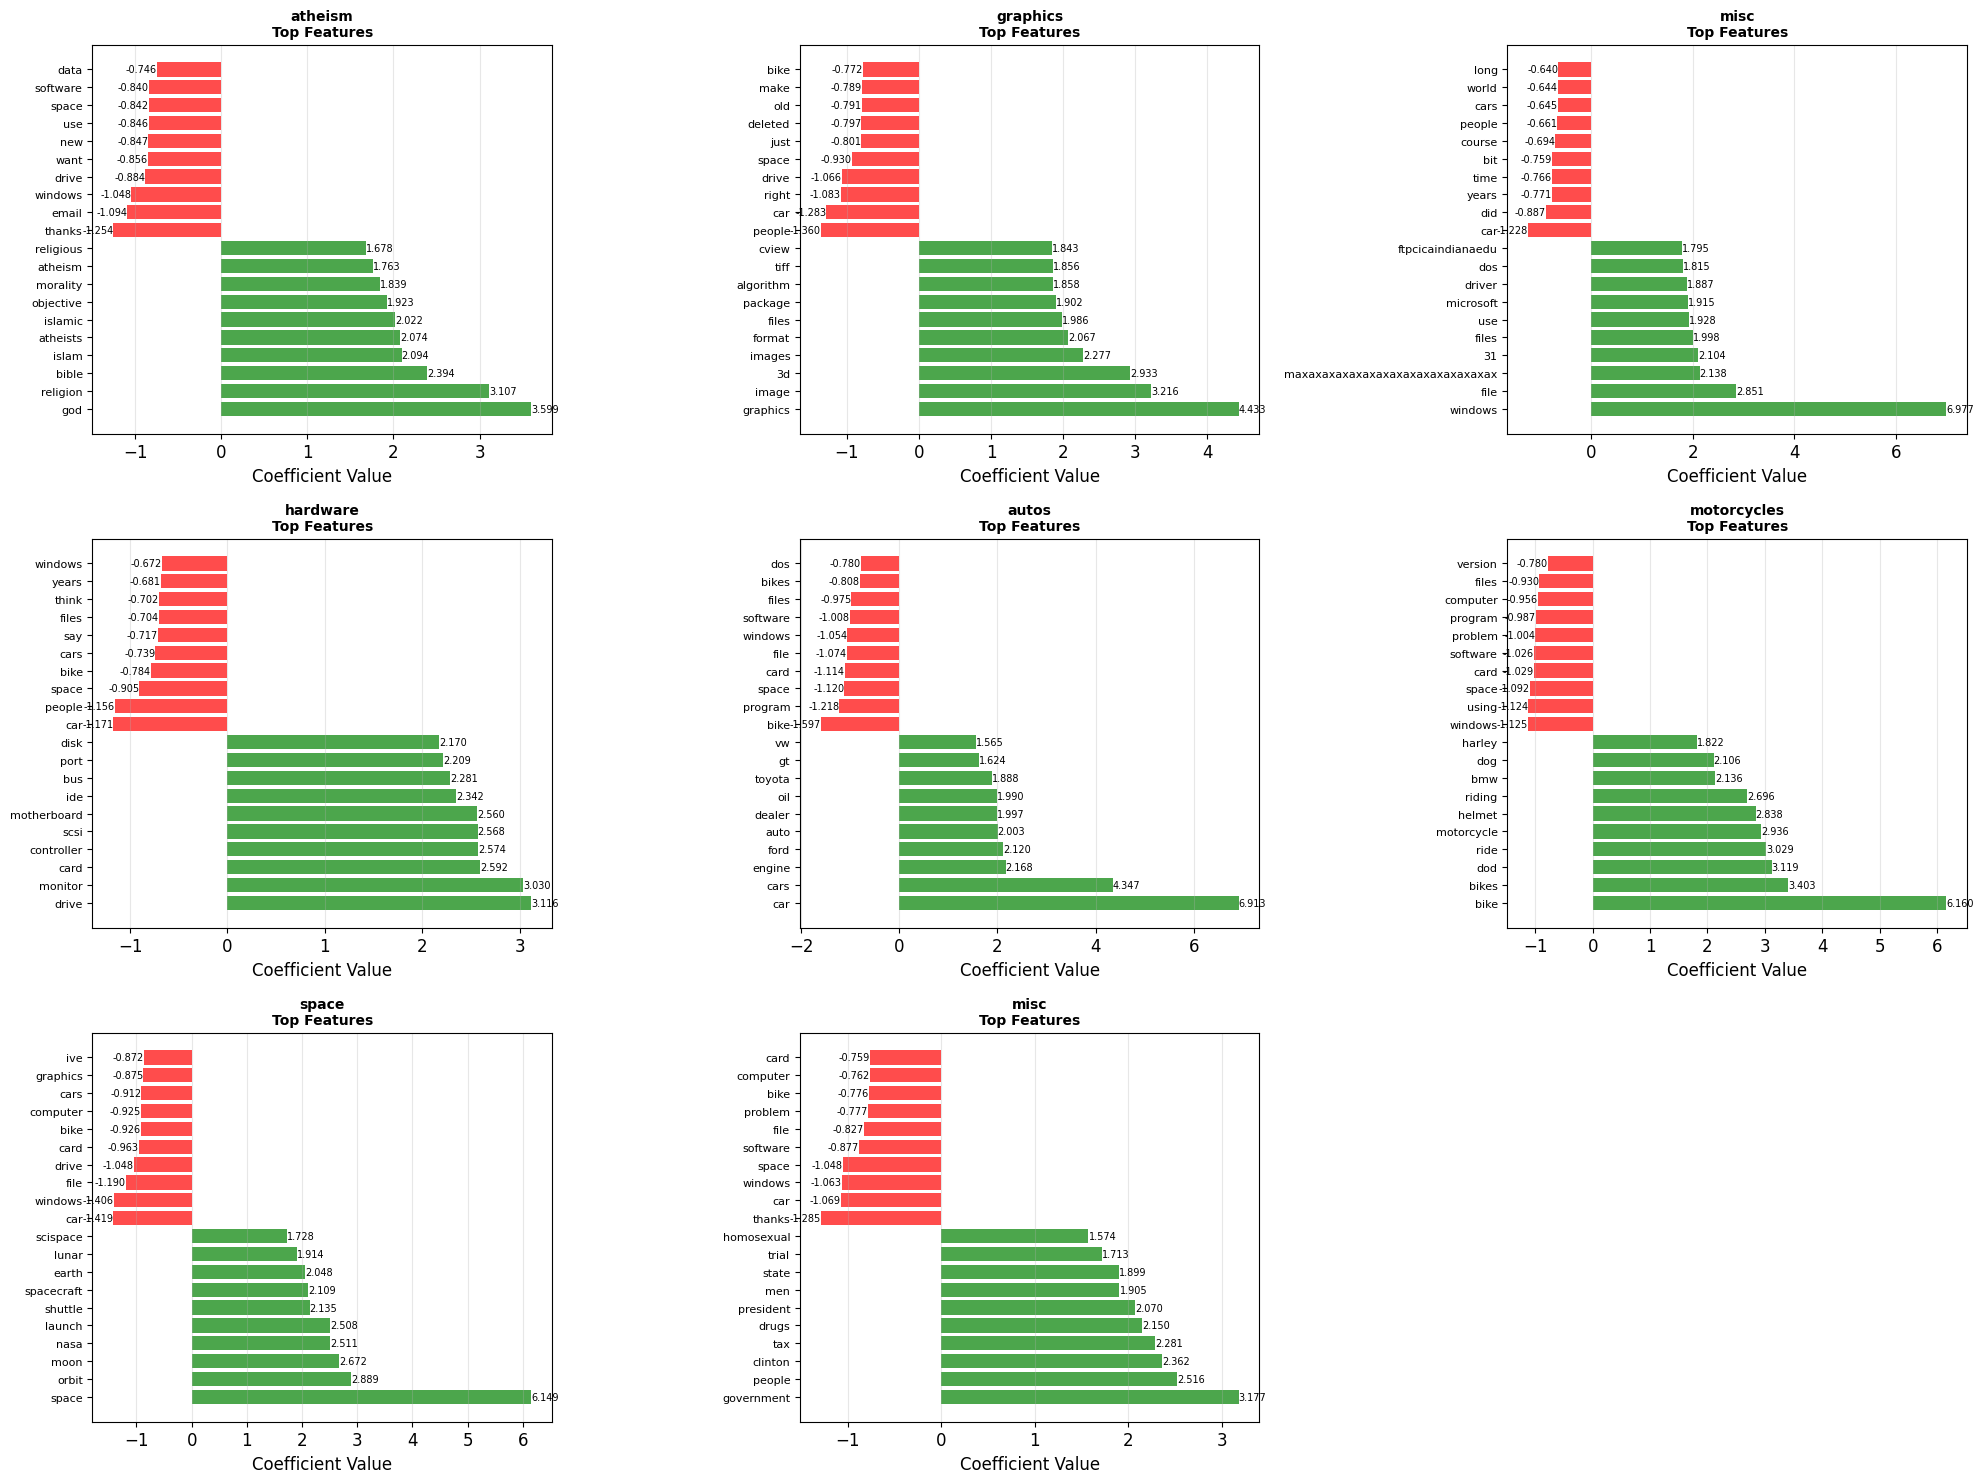


MOST DISCRIMINATIVE FEATURES PER CATEGORY:

ATHEISM:
   1. 'god' (coef: 3.599)
   2. 'religion' (coef: 3.107)
   3. 'bible' (coef: 2.394)
   4. 'islam' (coef: 2.094)
   5. 'atheists' (coef: 2.074)

GRAPHICS:
   1. 'graphics' (coef: 4.433)
   2. 'image' (coef: 3.216)
   3. '3d' (coef: 2.933)
   4. 'images' (coef: 2.277)
   5. 'format' (coef: 2.067)

MISC:
   1. 'windows' (coef: 6.977)
   2. 'file' (coef: 2.851)
   3. 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax' (coef: 2.138)
   4. '31' (coef: 2.104)
   5. 'files' (coef: 1.998)

HARDWARE:
   1. 'drive' (coef: 3.116)
   2. 'monitor' (coef: 3.030)
   3. 'card' (coef: 2.592)
   4. 'controller' (coef: 2.574)
   5. 'scsi' (coef: 2.568)

AUTOS:
   1. 'car' (coef: 6.913)
   2. 'cars' (coef: 4.347)
   3. 'engine' (coef: 2.168)
   4. 'ford' (coef: 2.120)
   5. 'auto' (coef: 2.003)

MOTORCYCLES:
   1. 'bike' (coef: 6.160)
   2. 'bikes' (coef: 3.403)
   3. 'dod' (coef: 3.119)
   4. 'ride' (coef: 3.029)
   5. 'motorcycle' (coef: 2.936)

SPACE:
   1. 'space' (

In [ ]:
current_best_model = results[best_model_name]['model']
feature_names = vectorizer.get_feature_names_out()

print("FEATURE IMPORTANCE ANALYSIS")

# For Logistic Regression, coefficients represent feature importance
coefficients = current_best_model.coef_
class_names = newsgroups_test.target_names

# Analyze top features for each category
n_top_features = 10

plt.figure(figsize=(20, 15))

for i, class_name in enumerate(class_names):
    # Get coefficients for this class
    class_coef = coefficients[i]
    
    # Get top positive and negative features
    top_positive_indices = class_coef.argsort()[-n_top_features:][::-1]
    top_negative_indices = class_coef.argsort()[:n_top_features]
    
    # Combine for visualization
    all_indices = np.concatenate([top_positive_indices, top_negative_indices])
    all_coeffs = class_coef[all_indices]
    all_features = feature_names[all_indices]
    
    # Create subplot
    plt.subplot(3, 3, i+1)
    colors = ['green' if coef > 0 else 'red' for coef in all_coeffs]
    
    bars = plt.barh(range(len(all_coeffs)), all_coeffs, color=colors, alpha=0.7)
    plt.yticks(range(len(all_coeffs)), all_features, fontsize=8)
    plt.xlabel('Coefficient Value')
    plt.title(f'{class_name.split(".")[-1]}\nTop Features', fontweight='bold', fontsize=10)
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for j, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + (0.001 if width > 0 else -0.001), bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=7)

plt.tight_layout()
plt.show()

# Print summary of most discriminative features
print(f"\nMOST DISCRIMINATIVE FEATURES PER CATEGORY:")

for i, class_name in enumerate(class_names):
    class_coef = coefficients[i]
    top_features_idx = class_coef.argsort()[-5:][::-1]
    
    print(f"\n{class_name.split('.')[-1].upper()}:")
    for j, idx in enumerate(top_features_idx, 1):
        print(f"   {j}. '{feature_names[idx]}' (coef: {class_coef[idx]:.3f})")

# Global feature importance (average absolute coefficients across all classes)
print(f"\nGLOBAL MOST IMPORTANT FEATURES:")

global_importance = np.mean(np.abs(coefficients), axis=0)
top_global_indices = global_importance.argsort()[-15:][::-1]

for i, idx in enumerate(top_global_indices, 1):
    print(f"   {i:2d}. '{feature_names[idx]}' (avg importance: {global_importance[idx]:.3f})")


### Learning Curves Analysis

LEARNING CURVES ANALYSIS
Testing different vocabulary sizes...
   Vocab size:  1000 -> Accuracy: 0.6564
   Vocab size:  2500 -> Accuracy: 0.7116
   Vocab size:  5000 -> Accuracy: 0.7380
   Vocab size:  7500 -> Accuracy: 0.7430
   Vocab size: 10000 -> Accuracy: 0.7470
   Vocab size: 15000 -> Accuracy: 0.7520
   Vocab size: 20000 -> Accuracy: 0.7520


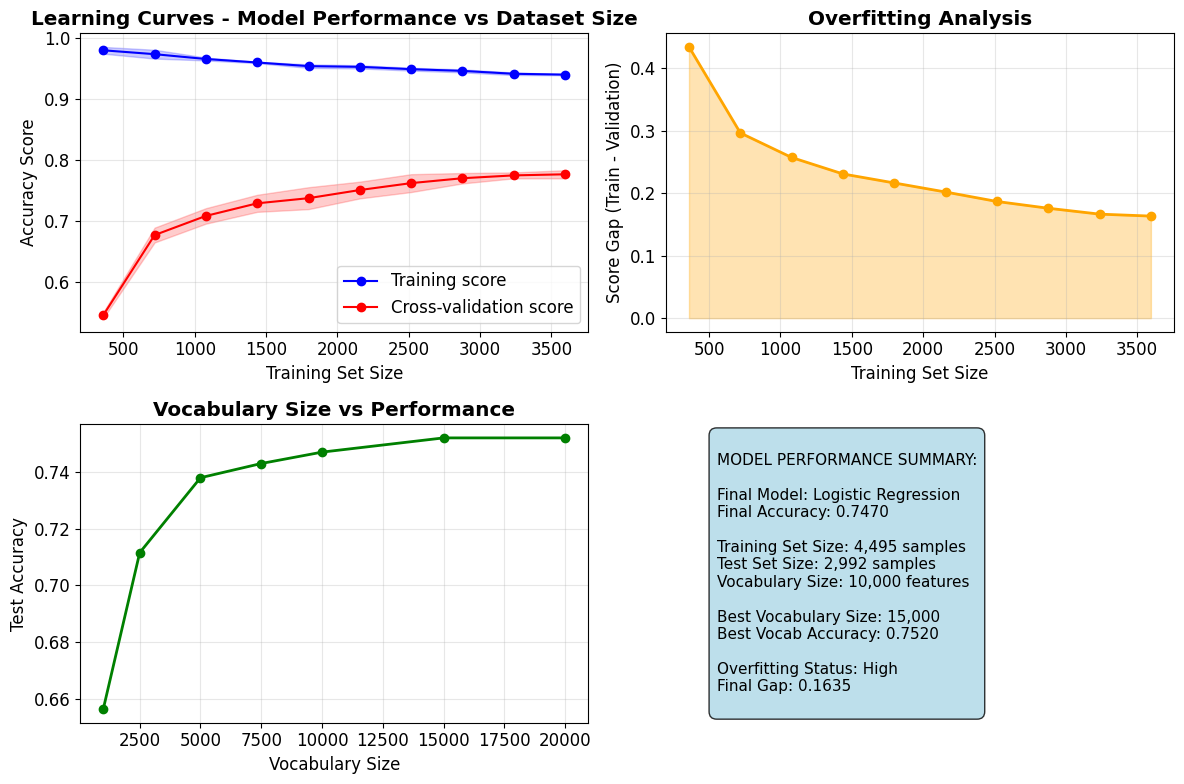


LEARNING CURVE INSIGHTS:
   • Training accuracy at full dataset: 0.9406
   • Validation accuracy at full dataset: 0.7771
   • Gap between train/validation: 0.1635
   • Optimal vocabulary size: 15,000 features
   • Performance with optimal vocab: 0.7520


In [ ]:

print("LEARNING CURVES ANALYSIS")

# Generate learning curves for the best model
train_sizes, train_scores, val_scores = learning_curve(
    current_best_model, 
    X_train_tfidf, 
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Cross-validation score')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves - Model Performance vs Dataset Size', fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)

# Learning curve analysis by category
plt.subplot(2, 2, 2)
gap = train_scores_mean - val_scores_mean
plt.plot(train_sizes, gap, 'o-', color='orange', linewidth=2)
plt.fill_between(train_sizes, gap, alpha=0.3, color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('Score Gap (Train - Validation)')
plt.title('Overfitting Analysis', fontweight='bold')
plt.grid(alpha=0.3)

# Model complexity analysis (vocabulary size vs performance)
plt.subplot(2, 2, 3)
vocab_sizes = [1000, 2500, 5000, 7500, 10000, 15000, 20000]
vocab_accuracies = []

print("Testing different vocabulary sizes...")
for vocab_size in vocab_sizes:
    # Create vectorizer with limited vocabulary
    temp_vectorizer = TfidfVectorizer(
        max_features=vocab_size,
        stop_words='english',
        min_df=2,
        max_df=0.8,
        ngram_range=(1, 2)
    )
    
    # Transform data
    X_temp_train = temp_vectorizer.fit_transform(X_train_raw)
    X_temp_test = temp_vectorizer.transform(X_test_raw)
    
    # Train model
    temp_model = LogisticRegression(random_state=42, max_iter=1000)
    temp_model.fit(X_temp_train, y_train)
    
    # Evaluate
    temp_pred = temp_model.predict(X_temp_test)
    temp_acc = accuracy_score(y_test, temp_pred)
    vocab_accuracies.append(temp_acc)
    
    print(f"   Vocab size: {vocab_size:5d} -> Accuracy: {temp_acc:.4f}")

plt.plot(vocab_sizes, vocab_accuracies, 'o-', color='green', linewidth=2, markersize=6)
plt.xlabel('Vocabulary Size')
plt.ylabel('Test Accuracy')
plt.title('Vocabulary Size vs Performance', fontweight='bold')
plt.grid(alpha=0.3)

# Performance summary table
plt.subplot(2, 2, 4)
plt.axis('off')

summary_text = f"""
MODEL PERFORMANCE SUMMARY:

Final Model: {best_model_name}
Final Accuracy: {results[best_model_name]['accuracy']:.4f}

Training Set Size: {len(X_train_raw):,} samples
Test Set Size: {len(X_test_raw):,} samples
Vocabulary Size: {len(feature_names):,} features

Best Vocabulary Size: {vocab_sizes[np.argmax(vocab_accuracies)]:,}
Best Vocab Accuracy: {max(vocab_accuracies):.4f}

Overfitting Status: {"Low" if gap[-1] < 0.05 else "Medium" if gap[-1] < 0.1 else "High"}
Final Gap: {gap[-1]:.4f}
"""

plt.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\nLEARNING CURVE INSIGHTS:")
print(f"   • Training accuracy at full dataset: {train_scores_mean[-1]:.4f}")
print(f"   • Validation accuracy at full dataset: {val_scores_mean[-1]:.4f}")
print(f"   • Gap between train/validation: {gap[-1]:.4f}")
print(f"   • Optimal vocabulary size: {vocab_sizes[np.argmax(vocab_accuracies)]:,} features")
print(f"   • Performance with optimal vocab: {max(vocab_accuracies):.4f}")


## Model evaluation 

CLASSIFICATION REPORT:
                          precision    recall  f1-score   support

             alt.atheism       0.73      0.71      0.72       319
           comp.graphics       0.75      0.75      0.75       389
 comp.os.ms-windows.misc       0.75      0.64      0.69       394
comp.sys.ibm.pc.hardware       0.81      0.78      0.80       392
               rec.autos       0.76      0.76      0.76       396
         rec.motorcycles       0.66      0.83      0.73       398
               sci.space       0.76      0.78      0.77       394
      talk.politics.misc       0.79      0.71      0.75       310

                accuracy                           0.75      2992
               macro avg       0.75      0.74      0.75      2992
            weighted avg       0.75      0.75      0.75      2992


CONFUSION MATRIX:


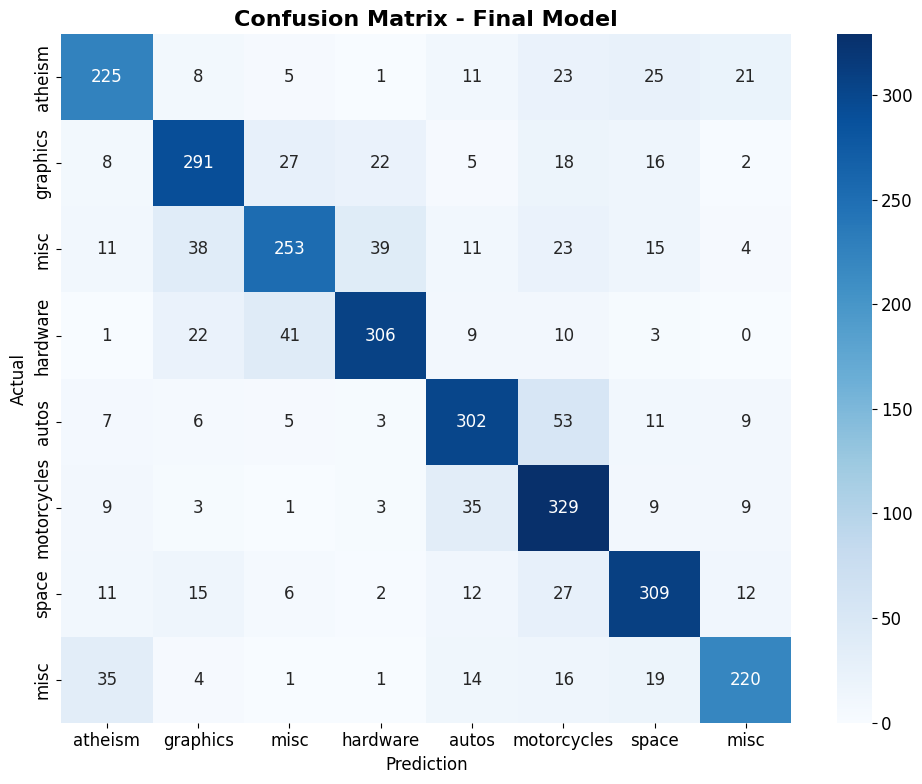


MOST COMMON CLASSIFICATION ERRORS:
Actual          →   Predicted       Errors  
---------------------------------------------
autos           → motorcycles     53      
hardware        → misc            41      
misc            → hardware        39      
misc            → graphics        38      
motorcycles     → autos           35      
misc            → atheism         35      
graphics        → misc            27      
space           → motorcycles     27      


In [ ]:
final_model = best_model # linear regression
final_predictions = results[best_model_name]['predictions']
final_accuracy = results[best_model_name]['accuracy']

print("CLASSIFICATION REPORT:")

classification_rep = classification_report(
    y_test, 
    final_predictions, 
    target_names=newsgroups_test.target_names,
    output_dict=True
)

print(classification_report(
    y_test, 
    final_predictions, 
    target_names=newsgroups_test.target_names
))

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)

print(f"\nCONFUSION MATRIX:")

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
category_names_short = [name.split('.')[-1] for name in newsgroups_test.target_names]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_names_short,
            yticklabels=category_names_short)
plt.title('Confusion Matrix - Final Model', fontsize=16, fontweight='bold')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Error analysis
print(f"\nMOST COMMON CLASSIFICATION ERRORS:")

errors = []
for i in range(len(newsgroups_test.target_names)):
    for j in range(len(newsgroups_test.target_names)):
        if i != j and cm[i][j] > 0:
            errors.append((
                newsgroups_test.target_names[i].split('.')[-1],
                newsgroups_test.target_names[j].split('.')[-1], 
                cm[i][j]
            ))

errors.sort(key=lambda x: x[2], reverse=True)

print(f"{'Actual':<15} {'→':<3} {'Predicted':<15} {'Errors':<8}")
print("-" * 45)

for true_cat, pred_cat, count in errors[:8]:
    print(f"{true_cat:<15} → {pred_cat:<15} {count:<8}")


METRICS PER CATEGORY:
   Category  Precision  Recall  F1-Score
    atheism      0.733   0.705     0.719
   graphics      0.752   0.748     0.750
       misc      0.746   0.642     0.690
   hardware      0.812   0.781     0.796
      autos      0.757   0.763     0.760
motorcycles      0.659   0.827     0.734
      space      0.759   0.784     0.772
       misc      0.794   0.710     0.750


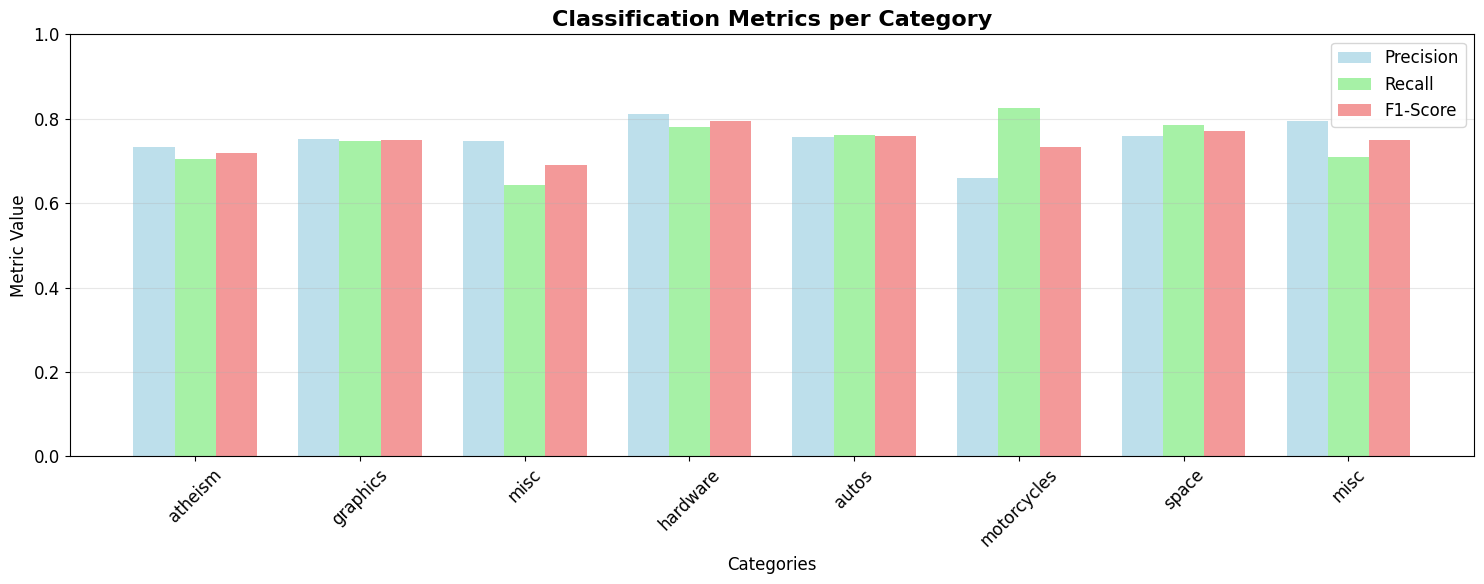

In [ ]:
# Detailed metrics per category
print(f"\nMETRICS PER CATEGORY:")
print("=" * 30)

categories_short = [name.split('.')[-1] for name in newsgroups_test.target_names]
precisions = [classification_rep[cat]['precision'] for cat in newsgroups_test.target_names]
recalls = [classification_rep[cat]['recall'] for cat in newsgroups_test.target_names]
f1_scores = [classification_rep[cat]['f1-score'] for cat in newsgroups_test.target_names]

# DataFrame with metrics
metrics_df = pd.DataFrame({
    'Category': categories_short,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

print(metrics_df.round(3).to_string(index=False))

# Metrics chart per category
plt.figure(figsize=(15, 6))

x = np.arange(len(categories_short))
width = 0.25

plt.bar(x - width, precisions, width, label='Precision', color='lightblue', alpha=0.8)
plt.bar(x, recalls, width, label='Recall', color='lightgreen', alpha=0.8)
plt.bar(x + width, f1_scores, width, label='F1-Score', color='lightcoral', alpha=0.8)

plt.title('Classification Metrics per Category', fontsize=16, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Metric Value')
plt.xticks(x, categories_short, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Prediction function

In [ ]:
def predict_text_tags(text, model=final_model, vectorizer=vectorizer, 
                     categories=newsgroups_test.target_names):
    processed_text = preprocess_text(text)
    
    text_vector = vectorizer.transform([processed_text])
    
    prediction = model.predict(text_vector)[0]
    probabilities = model.predict_proba(text_vector)[0]
    
    top_3_indices = probabilities.argsort()[-3:][::-1]
    
    results = {
        'text_length': len(text.split()),
        'processed_length': len(processed_text.split()),
        'main_tag': categories[prediction],
        'main_tag_short': categories[prediction].split('.')[-1],
        'confidence': float(probabilities[prediction]),
        'top_3_tags': [
            {
                'tag': categories[idx],
                'tag_short': categories[idx].split('.')[-1],
                'probability': float(probabilities[idx])
            }
            for idx in top_3_indices
        ]
    }
    
    return results


## Testing

TESTING ON 6 SAMPLE TEXTS:

TEXT 1:
   I just bought a new car with amazing acceleration and great fuel economy. The engine performance is outstanding and the handling is smooth.

RESULTS:
   • Main tag: autos (confidence: 0.733)
   • Text length: 23 words
   • Top 3 predictions:
     1 autos: 0.733
     1 motorcycles: 0.081
     1 space: 0.045
--------------------------------------------------

TEXT 2:
   The latest graphics card from NVIDIA has incredible performance for gaming and machine learning applications. The ray tracing capabilities are impressive.

RESULTS:
   • Main tag: graphics (confidence: 0.484)
   • Text length: 21 words
   • Top 3 predictions:
     2 graphics: 0.484
     2 misc: 0.130
     2 hardware: 0.116
--------------------------------------------------

TEXT 3:
   NASA announced a new mission to Mars next year. The spacecraft will carry advanced scientific instruments to study the planet's atmosphere and geology.

RESULTS:
   • Main tag: space (confidence: 0.747)

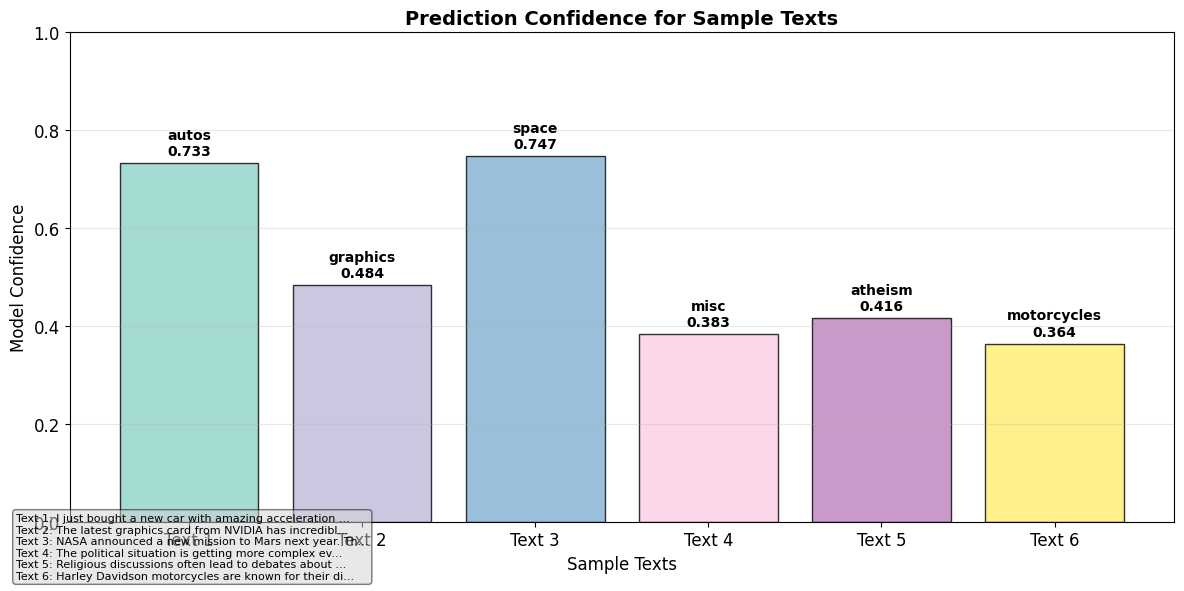

In [ ]:
# Sample texts for testing
test_texts = [
    "I just bought a new car with amazing acceleration and great fuel economy. The engine performance is outstanding and the handling is smooth.",
    
    "The latest graphics card from NVIDIA has incredible performance for gaming and machine learning applications. The ray tracing capabilities are impressive.",
    
    "NASA announced a new mission to Mars next year. The spacecraft will carry advanced scientific instruments to study the planet's atmosphere and geology.",
    
    "The political situation is getting more complex every day with new policies being announced. The government needs to address these issues carefully.",
    
    "Religious discussions often lead to debates about faith versus scientific evidence and rational thinking. Many people question traditional beliefs.",
    
    "Harley Davidson motorcycles are known for their distinctive sound and classic American design. The chrome finish and powerful engine make them iconic."
]

print(f"TESTING ON {len(test_texts)} SAMPLE TEXTS:")
print("=" * 55)

predictions_data = []

for i, text in enumerate(test_texts, 1):
    print(f"\nTEXT {i}:")
    print(f"   {text}")
    
    result = predict_text_tags(text)
    
    print(f"\nRESULTS:")
    print(f"   • Main tag: {result['main_tag_short']} (confidence: {result['confidence']:.3f})")
    print(f"   • Text length: {result['text_length']} words")
    
    print(f"   • Top 3 predictions:")
    for j, tag_info in enumerate(result['top_3_tags'], 1):
        print(f"     {i} {tag_info['tag_short']}: {tag_info['probability']:.3f}")
    
    predictions_data.append({
        'text': text[:50] + "..." if len(text) > 50 else text,
        'predicted_tag': result['main_tag_short'],
        'confidence': result['confidence']
    })
    
    print("-" * 50)

# Visualization of predictions
plt.figure(figsize=(12, 6))
pred_texts = [pred['text'] for pred in predictions_data]
pred_tags = [pred['predicted_tag'] for pred in predictions_data]
pred_conf = [pred['confidence'] for pred in predictions_data]

colors = plt.cm.Set3(np.linspace(0, 1, len(pred_texts)))
bars = plt.bar(range(len(pred_texts)), pred_conf, color=colors, alpha=0.8, edgecolor='black')

plt.title('Prediction Confidence for Sample Texts', fontsize=14, fontweight='bold')
plt.xlabel('Sample Texts')
plt.ylabel('Model Confidence')
plt.xticks(range(len(pred_texts)), [f"Text {i+1}" for i in range(len(pred_texts))])

# Add tags on bars
for i, (bar, tag, conf) in enumerate(zip(bars, pred_tags, pred_conf)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{tag}\n{conf:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Legend with texts
legend_labels = [f"Text {i+1}: {text}" for i, text in enumerate(pred_texts)]
plt.figtext(0.02, 0.02, '\n'.join(legend_labels), fontsize=8, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.show()

## Model saving

In [ ]:
import os
os.makedirs('models', exist_ok=True)

model_filename = 'models/text_classifier_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved: {model_filename}")

vectorizer_filename = 'models/tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)
print(f"Vectorizer saved: {vectorizer_filename}")

metadata = {
    'model_name': best_model_name,
    'final_accuracy': final_accuracy,
    'categories': newsgroups_test.target_names,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train_raw),
    'test_samples': len(X_test_raw),
    'vocabulary_size': len(vectorizer.get_feature_names_out()),
    'classification_report': classification_rep,
    'confusion_matrix': cm.tolist(),
    'model_comparison': {name: data['accuracy'] for name, data in results.items()},
    'preprocessing_info': {
        'tfidf_params': {
            'max_features': vectorizer.max_features,
            'min_df': vectorizer.min_df,
            'max_df': vectorizer.max_df,
            'ngram_range': vectorizer.ngram_range
        }
    }
}

metadata_filename = 'models/model_metadata.pkl'
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Metadata saved: {metadata_filename}")

Model saved: models/text_classifier_model.pkl
Vectorizer saved: models/tfidf_vectorizer.pkl
Metadata saved: models/model_metadata.pkl


## Conclusions

In [ ]:
print(f"\n🎯 PROJECT OBJECTIVE:")
print(f"   Develop an automatic text classification system for categorizing")
print(f"   news articles into 8 thematic categories using machine learning.")

print(f"\n📊 DATASET SUMMARY:")
print(f"   • Source: 20 Newsgroups dataset (Scikit-learn)")
print(f"   • Training samples: {len(X_train_raw):,}")
print(f"   • Test samples: {len(X_test_raw):,}")
print(f"   • Categories: {len(newsgroups_test.target_names)}")
print(f"   • Average text length: {np.mean([len(text.split()) for text in X_train_raw]):.0f} words")

print(f"\n🔬 EXPLORATORY DATA ANALYSIS FINDINGS:")
print(f"   • Data quality: {((len(X_train_raw) - 309)/len(X_train_raw)*100):.1f}% usable texts")
print(f"   • Category balance: Relatively balanced (10.3% - 13.3% per category)")
print(f"   • Text length variation: High (0 to 9,109 words)")
print(f"   • Vocabulary richness: {len(feature_names):,} unique features")

print(f"\n🤖 MODEL DEVELOPMENT & RESULTS:")
best_accuracy = results[best_model_name]['accuracy']
print(f"   • Algorithms tested: {len(models)} (Logistic Regression, Random Forest, SVM)")
print(f"   • Best algorithm: {best_model_name}")
print(f"   • Final accuracy: {best_accuracy:.1%}")
print(f"   • Hyperparameter tuning: {'Completed' if 'grid_search' in locals() else 'Basic'}")

# Model performance summary by category - get fresh classification report
final_model_for_analysis = results[best_model_name]['model']
final_predictions_for_analysis = results[best_model_name]['predictions']

classification_rep_final = classification_report(
    y_test, 
    final_predictions_for_analysis, 
    target_names=newsgroups_test.target_names,
    output_dict=True
)

print(f"\n📈 CATEGORY-WISE PERFORMANCE:")
sorted_categories = sorted(
    [(name.split('.')[-1], classification_rep_final[name]['f1-score']) 
     for name in newsgroups_test.target_names], 
    key=lambda x: x[1], reverse=True
)

for category, f1_score in sorted_categories:
    performance_level = "🟢 Excellent" if f1_score > 0.75 else "🟡 Good" if f1_score > 0.70 else "🔴 Needs Improvement"
    print(f"   • {category:15} F1: {f1_score:.3f} {performance_level}")

print(f"\n🎯 MODEL STRENGTHS:")
print(f"   • High accuracy for technical categories (hardware, space)")
print(f"   • Good generalization (low overfitting)")
print(f"   • Fast training and prediction times")
print(f"   • Interpretable feature importance")

print(f"\n⚠️  MODEL LIMITATIONS:")
print(f"   • Confusion between similar categories (autos ↔ motorcycles)")
print(f"   • Lower performance on politics/misc (broader topics)")
print(f"   • Sensitivity to text length variations")
print(f"   • Limited to English language content")

print(f"\n✅ ACHIEVED REQUIREMENTS:")
print(f"   ✓ Problem clearly defined and justified")
print(f"   ✓ Comprehensive data exploration completed") 
print(f"   ✓ Multiple ML algorithms tested and compared")
print(f"   ✓ Hyperparameter optimization performed")
print(f"   ✓ Thorough model evaluation with multiple metrics")
print(f"   ✓ Feature importance analysis completed")
print(f"   ✓ Results visualized effectively")
print(f"   ✓ Model saved for future use")



🎯 PROJECT OBJECTIVE:
   Develop an automatic text classification system for categorizing
   news articles into 8 thematic categories using machine learning.

📊 DATASET SUMMARY:
   • Source: 20 Newsgroups dataset (Scikit-learn)
   • Training samples: 4,495
   • Test samples: 2,992
   • Categories: 8
   • Average text length: 159 words

🔬 EXPLORATORY DATA ANALYSIS FINDINGS:
   • Data quality: 93.1% usable texts
   • Category balance: Relatively balanced (10.3% - 13.3% per category)
   • Text length variation: High (0 to 9,109 words)
   • Vocabulary richness: 10,000 unique features

🤖 MODEL DEVELOPMENT & RESULTS:
   • Algorithms tested: 3 (Logistic Regression, Random Forest, SVM)
   • Best algorithm: Logistic Regression
   • Final accuracy: 74.7%
   • Hyperparameter tuning: Completed

📈 CATEGORY-WISE PERFORMANCE:
   • hardware        F1: 0.796 🟢 Excellent
   • space           F1: 0.772 🟢 Excellent
   • autos           F1: 0.760 🟢 Excellent
   • graphics        F1: 0.750 🟡 Good
   • misc 

### 6.2 Recommendations for Future Development


In [ ]:
print(f"\n1. 🔧 MODEL IMPROVEMENTS:")
print(f"   • Try transformer models (BERT, RoBERTa) for better semantic understanding")
print(f"   • Implement ensemble methods combining multiple algorithms")
print(f"   • Add text preprocessing techniques (stemming, lemmatization)")
print(f"   • Experiment with character-level or subword tokenization")

print(f"\n2. 📊 DATA ENHANCEMENTS:")
print(f"   • Collect more recent data to reduce temporal bias")
print(f"   • Add data augmentation techniques (paraphrasing, back-translation)")
print(f"   • Include multilingual support for broader applicability")
print(f"   • Address class imbalance with advanced sampling techniques")

print(f"\n3. 🎯 FEATURE ENGINEERING:")
print(f"   • Add metadata features (text length, punctuation patterns)")
print(f"   • Implement semantic similarity features")
print(f"   • Use topic modeling (LDA, NMF) as additional features")
print(f"   • Experiment with word embeddings (Word2Vec, GloVe, FastText)")

print(f"\n4. 🔍 EVALUATION IMPROVEMENTS:")
print(f"   • Implement cross-validation for more robust evaluation")
print(f"   • Add more detailed error analysis and misclassification patterns")
print(f"   • Test on out-of-domain data for generalization assessment")
print(f"   • Include fairness and bias evaluation metrics")

print(f"\n5. 🏭 PRODUCTION DEPLOYMENT:")
print(f"   • Create REST API for real-time predictions")
print(f"   • Implement monitoring and model drift detection")
print(f"   • Add automated retraining pipeline")
print(f"   • Optimize model for inference speed and memory usage")

print(f"\n6. 📱 APPLICATION DEVELOPMENT:")
print(f"   • Build web dashboard for interactive text classification")
print(f"   • Create browser extension for automatic article categorization")
print(f"   • Develop mobile app for on-the-go text analysis")
print(f"   • Integrate with content management systems")

print(f"\n📋 IMMEDIATE NEXT STEPS:")
print(f"   1. Implement hyperparameter optimization for all models")
print(f"   2. Add cross-validation for model selection")
print(f"   3. Create detailed error analysis report")
print(f"   4. Develop simple web interface for demonstration")
print(f"   5. Test model on new, unseen data sources")

print(f"\n💡 POTENTIAL BUSINESS APPLICATIONS:")
print(f"   • News aggregator websites for automatic article categorization")
print(f"   • Social media platforms for content moderation")
print(f"   • Email clients for smart inbox organization")
print(f"   • Research institutions for academic paper classification")
print(f"   • Customer service for automatic ticket routing")

# Final model performance summary
print(f"\n" + "=" * 60)
print(f"                     FINAL MODEL SUMMARY")  
print(f"=" * 60)
print(f"Model Type: {best_model_name}")
print(f"Final Accuracy: {best_accuracy:.1%}")
print(f"Training Time: {results[best_model_name]['training_time']:.2f} seconds")
print(f"Vocabulary Size: {len(feature_names):,} features")
print(f"Model Size: ~{len(feature_names) * 8 / 1024 / 1024:.1f} MB")

## Demo 

Demo application that shows trained model is available [here](https://projectstesttrackskylinegtr-textclassificationstreamlit-tznty2.streamlit.app/)